In [37]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sys import platform
import os

from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint



# **MODEL CREATION** #

''' Hacer orimero que cada palabra de la columna messages sea una linea de un nuevo dataframe.
mirar las palabras mas repetidas.
Asociar valores a las palabras y crear dataframe
en mi dataframe pero copia poner columna por cada tag que encuentre.
despues a partir de aquí asociarle emociones
y construir el modelo.'''

'''NLP LEMMATIZATION
generar nova columna per lemmatization stemming'''

'''Trobar formula del sample minim que necessito per ser representatiu
per agafar el sample random 
llistat emocions dataframe

dels 1000 missatges anar un per un i classificar

entreno sobre els 1000 per trobar el millor model

entreno despres sobre tot el sample i despres ja li poso a tot el meu dataset

fer bootstrapping i fer el m, bootstrapping statistics'''

x boost, random forest, 
amarquescancio@gmail.com

In [5]:
df = pd.read_csv("../data/translation/completo.csv")

In [6]:
df.shape

(118752, 4)

## FIND THE MINIMUM REPRESENTATIVE SAMPLE

In [7]:
import math

# Datos
N = 118752  # Tamaño total de la población
Z = 1.96    # Valor crítico para un nivel de confianza del 95%
E = 0.05    # Margen de error del 5%
p = 0.5     # Estimación de la proporción

# Fórmula para calcular el tamaño de la muestra
n = (N * Z**2 * p * (1 - p)) / ((E**2 * (N - 1)) + Z**2 * p * (1 - p))

# Redondear hacia arriba ya que no puedes tener fracciones de personas en tu muestra
n = math.ceil(n)

print(f"Min necessary sample: {n}")


Min necessary sample: 383


Even though it says the minimmum sample can be 383 I'm going to catch 1000 to be sure to cover all 3 languages.

audio, image, video = neutral

In [8]:
'''def get_random_df(df):

    df = df[(df["message"].str.lower() != "\u200eaudio ") & (df["message"].str.lower() != "\u200evideo ")]
    df = df[df["message"].str.lower() != "\u200eimage "] 

    sample_df = df.sample(n=1000, random_state=42, ignore_index=True)
    return sample_df

sdf = get_random_df(df)'''

'def get_random_df(df):\n\n    df = df[(df["message"].str.lower() != "\u200eaudio ") & (df["message"].str.lower() != "\u200evideo ")]\n    df = df[df["message"].str.lower() != "\u200eimage "] \n\n    sample_df = df.sample(n=1000, random_state=42, ignore_index=True)\n    return sample_df\n\nsdf = get_random_df(df)'

In [9]:
'''sdf.sample(30)'''

'sdf.sample(30)'

## PREPARE TO MANUALLY INPUT THE CLASSIFICATED EMOTIONS FOR THIS SAMPLE

In [10]:
#sdf['classification'] = None

In [11]:
#sdf.to_csv("../data/translation/to_classify.csv")

In [12]:
emotions= [{"sadness":1},
           {"joy":2},
           {"fear":3},
           {"anger":4},
           {"surprise":5},
           {"defensive":6},
           {"nostalgia":7},
           {"hapiness":8},
           {"stressed":9},
           {"expectant":10},
           {"insecure":11},
           {"assertivity":12},
           {"neutral":13},
           {"excitement":14},
           {"comprehensive":15},
           {"helpless":16},
           {"love":17},
           {"deception":18},
           {"doubtful":19},
           {"picarona":20}]

## IMPORT THE LABELED DF

In [13]:
cdf = pd.read_csv("../data/translation/classified.csv", sep=";")
cdf.drop(columns="Unnamed: 0", inplace=True)
cdf

,date,time,name,message,emotion
0,2023-04-09,13:33:57,Em,Quan acabo et truco,12
1,2019-12-04,17:32:34,Em,Tia pero escucha haz abdominales si queires ha...,14
2,2020-06-16,17:12:10,Em,Si ara mateix,9
3,2018-08-07,15:10:52,Em,41577827Z,13
4,2019-03-10,10:57:46,Em,Ya me contaras como ha ido,10
...,...,...,...,...,...
995,2021-11-25,21:14:54,Em,Quina vidaaa!!! Estic same literal,8
996,2023-08-03,23:22:13,Em,Como ha ido tu diaa?,15
997,2020-07-02,13:38:15,Em,Okay,13
998,2021-02-02,20:54:18,Em,Etc,13


I need to associate power to some and less to others. neutral 13 and 12 less value.

## MODEL CHOOSING

DICTIONARY WITH EMOTIONS

In [14]:
emotions_2 = {list(i.values())[0]: list(i.keys())[0] for i in emotions}
emotions_2

{1: 'sadness',
 2: 'joy',
 3: 'fear',
 4: 'anger',
 5: 'surprise',
 6: 'defensive',
 7: 'nostalgia',
 8: 'hapiness',
 9: 'stressed',
 10: 'expectant',
 11: 'insecure',
 12: 'assertivity',
 13: 'neutral',
 14: 'excitement',
 15: 'comprehensive',
 16: 'helpless',
 17: 'love',
 18: 'deception',
 19: 'doubtful',
 20: 'picarona'}

In [15]:
'''def many_models_at_once (df, test_size=0.2, n_iterations=1000):

    
    X = df["message"]
    y = df["emotion"]
    
    # 0. Train / test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

    # Vectorize
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
    X_test_tfidf = vectorizer.transform(X_test).toarray()
    
    models = {
        "lr": LogisticRegression(),
        "multinomial": MultinomialNB(),
        #"neural_net": MLPClassifier(), 
        "gaussian": GaussianNB(),
        "knc": KNeighborsClassifier(),
        "grad": GradientBoostingClassifier(random_state=42),
        "tree": DecisionTreeClassifier(),
        "forest": RandomForestClassifier(random_state=42),
        "svc": SVC(kernel='poly'),
        "xgcb": XGBClassifier()
    }
  
    for model in models.values():

        #.Bootstrapping
        accuracy_bootstrap = []

        for _ in range(n_iterations):
            X_bs, y_bs = resample(X_train_tfidf, y_train)
            model.fit(X_bs, y_bs)
            y_pred = model.predict(X_test_tfidf)
            accuracy = metrics.accuracy_score(y_test, y_pred)
            accuracy_bootstrap.append(accuracy)


    for name, model in models.items():

        print(f"------------{name}------------\n")
        print(f"Average Accuracy: {np.mean(accuracy_bootstrap):.4f}")
        print(f"Standard Deviation: {np.std(accuracy_bootstrap):.4f}")

        # Additional metrics if needed
        print(f"Precision: {metrics.precision_score(y_test, y_pred, average='weighted'):.4f}")
        print(f"Recall: {metrics.recall_score(y_test, y_pred, average='weighted'):.4f}")
        print(f"F1 Score: {metrics.f1_score(y_test, y_pred, average='weighted'):.4f}")
        print("\n")
        
proba = many_models_at_once (cdf, test_size = 0.2, n_iterations=1000)
proba'''

'def many_models_at_once (df, test_size=0.2, n_iterations=1000):\n\n    \n    X = df["message"]\n    y = df["emotion"]\n    \n    # 0. Train / test split\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)\n\n    # Vectorize\n    vectorizer = TfidfVectorizer()\n    X_train_tfidf = vectorizer.fit_transform(X_train).toarray()\n    X_test_tfidf = vectorizer.transform(X_test).toarray()\n    \n    models = {\n        "lr": LogisticRegression(),\n        "multinomial": MultinomialNB(),\n        #"neural_net": MLPClassifier(), \n        "gaussian": GaussianNB(),\n        "knc": KNeighborsClassifier(),\n        "grad": GradientBoostingClassifier(random_state=42),\n        "tree": DecisionTreeClassifier(),\n        "forest": RandomForestClassifier(random_state=42),\n        "svc": SVC(kernel=\'poly\'),\n        "xgcb": XGBClassifier()\n    }\n  \n    for model in models.values():\n\n        #.Bootstrapping\n        accuracy_bootstrap = []\n\n        for _ in ra

TRY MODELS WITH BOOTSTRAPPING

In [16]:
def try_model(model, df, n_iterations=1000, test_size=0.2):

    '''Function to try models.
    It takes 4 args:
    - model
    - df
    - n_interactions
    - test_size
    '''
    
    X = df["message"]
    y = df["emotion"]
    
    # 0. Train / test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

    # Vectorize
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    accuracy_bootstrap = []

    for _ in range(n_iterations):
        X_bs, y_bs = resample(X_train_tfidf, y_train)
        model.fit(X_bs, y_bs)
        y_pred = model.predict(X_test_tfidf)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        accuracy_bootstrap.append(accuracy)

    print(f"------------notas------------\n")
    print(f"Average Accuracy: {np.mean(accuracy_bootstrap):.4f}")
    print(f"Standard Deviation: {np.std(accuracy_bootstrap):.4f}")

    # Additional metrics if needed
    print(f"Precision: {metrics.precision_score(y_test, y_pred, average='weighted',zero_division=1):.4f}")
    print(f"Recall: {metrics.recall_score(y_test, y_pred, average='weighted',zero_division=1):.4f}")
    print(f"F1 Score: {metrics.f1_score(y_test, y_pred, average='weighted',zero_division=1):.4f}")
    print("\n")



In [17]:
multinomial = try_model(MultinomialNB(), cdf, n_iterations=1000, test_size=0.2)

------------notas------------

Average Accuracy: 0.2674
Standard Deviation: 0.0188
Precision: 0.5954
Recall: 0.2850
F1 Score: 0.2700




In [19]:
knc = try_model(KNeighborsClassifier(), cdf, n_iterations=1000, test_size=0.2)

------------notas------------

Average Accuracy: 0.1665
Standard Deviation: 0.0368
Precision: 0.2876
Recall: 0.2450
F1 Score: 0.4535




In [23]:
tree = try_model(DecisionTreeClassifier(), cdf, n_iterations=1000, test_size=0.2)

------------notas------------

Average Accuracy: 0.1927
Standard Deviation: 0.0339
Precision: 0.2157
Recall: 0.2450
F1 Score: 0.4531




In [24]:
forest = try_model(RandomForestClassifier(), cdf, n_iterations=1000, test_size=0.2)

------------notas------------

Average Accuracy: 0.2291
Standard Deviation: 0.0229
Precision: 0.3236
Recall: 0.2300
F1 Score: 0.3160




In [25]:
svc = try_model(SVC(kernel='poly'), cdf, n_iterations=1000, test_size=0.2)

------------notas------------

Average Accuracy: 0.2362
Standard Deviation: 0.0102
Precision: 0.6876
Recall: 0.2400
F1 Score: 0.1654




In [26]:

def get_boost(df, test_size=0.2, n_iterations=1000):
    X = df["message"]
    y = df["emotion"]

    # Train / test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Vectorize
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train).toarray()  # Convert to dense array
    X_test_tfidf = vectorizer.transform(X_test).toarray()  # Convert to dense array

    # Adjust class labels to start from 0
    y_train_adjusted = y_train - 1
    y_test_adjusted = y_test - 1

    # ...

    # Adjust class labels to start from 0
    y_train_adjusted = y_train - 1
    y_test_adjusted = y_test - 1

    # Check unique classes in y after adjustment
    unique_classes_train = np.unique(y_train_adjusted)
    unique_classes_test = np.unique(y_test_adjusted)
    print("Unique Classes (Train):", unique_classes_train)
    print("Unique Classes (Test):", unique_classes_test)

    # Define XGBClassifier
    model = XGBClassifier()

    # Bootstrapping
    accuracy_bootstrap = []

    for _ in range(n_iterations):
        X_bs, y_bs = resample(X_train_tfidf, y_train_adjusted)
        print("model resampled")
        model.fit(X_bs, y_bs)
        print("model fitted")
        y_pred = model.predict(X_test_tfidf)
        accuracy = metrics.accuracy_score(y_test_adjusted, y_pred)
        accuracy_bootstrap.append(accuracy)

    # Display results
    print(f"------------XGBClassifier------------\n")
    print(f"Average Accuracy: {np.mean(accuracy_bootstrap):.4f}")
    print(f"Standard Deviation: {np.std(accuracy_bootstrap):.4f}")
    # Additional metrics if needed
    print(f"Precision: {metrics.precision_score(y_test_adjusted, y_pred, average='weighted', zero_division=1):.4f}")
    print(f"Recall: {metrics.recall_score(y_test_adjusted, y_pred, average='weighted', zero_division=1):.4f}")
    print(f"F1 Score: {metrics.f1_score(y_test_adjusted, y_pred, average='weighted', zero_division=1):.4f}")
    print("\n")


In [27]:
xgcb = get_boost(cdf, n_iterations=1000, test_size=0.2)

Unique Classes (Train): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Unique Classes (Test): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
model resampled


model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
model resampled
model fitted
m

TRY MODELS WITHOUT BOOTSTRAPPING

In [20]:
def try_model_v(model, df, test_size=0.2):

    '''Function to try models.
    It takes 4 args:
    - model
    - df
    - n_interactions
    - test_size
    '''
    
    X = df["message"]
    y = df["emotion"]
    
    # 0. Train / test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

    # Vectorize
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)


    print(f"------------notas------------\n")

    # Additional metrics if needed
    print(f"Precision: {metrics.precision_score(y_test, y_pred, average='weighted',zero_division=1):.4f}")
    print(f"Recall: {metrics.recall_score(y_test, y_pred, average='weighted',zero_division=1):.4f}")
    print(f"F1 Score: {metrics.f1_score(y_test, y_pred, average='weighted',zero_division=1):.4f}")
    print("\n")

In [31]:
def get_boost_v(df, test_size=0.2):
    X = df["message"]
    y = df["emotion"]

    # Train / test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Define XGBClassifier
    model = XGBClassifier()

    # Vectorize
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train).toarray()  # Convert to dense array
    X_test_tfidf = vectorizer.transform(X_test).toarray()  # Convert to dense array

    # Adjust class labels to start from 0
    y_train_adjusted = y_train - 1
    y_test_adjusted = y_test - 1

    model.fit(X_train_tfidf, y_train_adjusted)
    y_pred = model.predict(X_test_tfidf)

    # Check unique classes in y after adjustment
    unique_classes_train = np.unique(y_train_adjusted)
    unique_classes_test = np.unique(y_test_adjusted)
    print("Unique Classes (Train):", unique_classes_train)
    print("Unique Classes (Test):", unique_classes_test)


    # Display results
    print(f"------------XGBClassifier------------\n")
    # Additional metrics if needed
    print(f"Precision: {metrics.precision_score(y_test_adjusted, y_pred, average='weighted', zero_division=1):.4f}")
    print(f"Recall: {metrics.recall_score(y_test_adjusted, y_pred, average='weighted', zero_division=1):.4f}")
    print(f"F1 Score: {metrics.f1_score(y_test_adjusted, y_pred, average='weighted', zero_division=1):.4f}")
    print("\n")

In [21]:
knc_ = try_model_v(KNeighborsClassifier(), cdf, test_size=0.2)

------------notas------------

Precision: 0.3994
Recall: 0.1600
F1 Score: 0.3420




In [36]:
tree_v = try_model_v(DecisionTreeClassifier(), cdf,test_size=0.2)

------------notas------------

Precision: 0.2712
Recall: 0.2300
F1 Score: 0.3426




In [32]:
xgc = get_boost_v(cdf,test_size=0.2)

Unique Classes (Train): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Unique Classes (Test): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
------------XGBClassifier------------

Precision: 0.1743
Recall: 0.1800
F1 Score: 0.5310




In [34]:
xgc_ = get_boost_v(cdf,test_size=0.1)

Unique Classes (Train): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Unique Classes (Test): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19]
------------XGBClassifier------------

Precision: 0.1294
Recall: 0.1300
F1 Score: 0.6985




GET THE BEST PARAMETERS FOR X BOOST

In [43]:

def best_var_boost(df, test_size=0.2):
    '''Function to find the best parameters for an XGBoost Classifier.
    It takes 2 args:
    - df
    - test size'''

    # Split the data into training and testing sets
    X = df["message"]
    y = df["emotion"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Vectorize the text data
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
    X_test_tfidf = vectorizer.transform(X_test).toarray()

    # Adjust class labels to start from 0
    y_train_adjusted = y_train - 1
    y_test_adjusted = y_test - 1

    # Define the hyperparameter distribution
    param_dist = {
        'n_estimators': randint(50, 200),
        'max_depth': [None, 10, 20, 30]
    }

    # Create the XGBClassifier model
    model = XGBClassifier()

    # Create the RandomizedSearchCV object
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                       n_iter=10, scoring='f1_weighted', cv=5, random_state=42)

    # Fit the model to the data
    random_search.fit(X_train_tfidf, y_train_adjusted)

    # Get the best hyperparameters
    best_params_random = random_search.best_params_
    print("Best Hyperparameters (Random Search):", best_params_random)

    # Get the best model
    best_model_random = random_search.best_estimator_

    # Make predictions on the test set
    y_pred_best = best_model_random.predict(X_test_tfidf)

    # Evaluate the model
    f1_best = metrics.f1_score(y_test_adjusted, y_pred_best, average='weighted', zero_division=1)
    print(f"F1 Score (Best Model): {f1_best}")



In [44]:
best_params_xgcb = best_var_boost(cdf, test_size=0.2)

Best Hyperparameters (Random Search): {'max_depth': 30, 'n_estimators': 180}
F1 Score (Best Model): 0.4645966316292403


As we can see it works better without parameters. So now we can predict our full dataset with the original model.

GET THE BEST PARAMETERS FOR TREE

In [79]:
def best_var_tree(df, test_size=0.2):
    '''Function to find the best parameters for an XGBoost Classifier.
    It takes 2 args:
    - df
    - test size'''

    # Split the data into training and testing sets
    X = df["message"]
    y = df["emotion"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Vectorize the text data
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
    X_test_tfidf = vectorizer.transform(X_test).toarray()

    param_dist = {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
    }


    # Create the XGBClassifier model
    model = DecisionTreeClassifier()

    # Create the RandomizedSearchCV object
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                       n_iter=10, scoring='f1_weighted', cv=5, random_state=42)

    # Fit the model to the data
    random_search.fit(X_train_tfidf, y_train)

    # Get the best hyperparameters
    best_params_random = random_search.best_params_
    print("Best Hyperparameters (Random Search):", best_params_random)

    # Get the best model
    best_model_random = random_search.best_estimator_

    # Make predictions on the test set
    y_pred_best = best_model_random.predict(X_test_tfidf)

    # Evaluate the model
    f1_best = metrics.f1_score(y_test, y_pred_best, average='weighted', zero_division=1)
    print(f"F1 Score (Best Model): {f1_best}")

In [82]:
best_params_tree = best_var_tree(cdf, test_size=0.3)

Best Hyperparameters (Random Search): {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'entropy'}
F1 Score (Best Model): 0.4325780214402901


APPLY THE MODEL TO THE FULL DATASET X BOOST

In [96]:
def apply_model(df,df_2 ,test_size=0.2):

    '''Function to apply the trained model to my full dataframe. It also plots.
    It takes 3 args:
    - df model
    - dataframe to predict
    - test size'''

    X = df["message"]
    y = df["emotion"]

    # Train / test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Define XGBClassifier
    model = XGBClassifier(max_depth= 30, n_estimators= 180)

    # Vectorize
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)#.toarray()  # Convert to dense array
    X_test_tfidf = vectorizer.transform(X_test)#.toarray()  # Convert to dense array

    # Adjust class labels to start from 0
    y_train_adjusted = y_train - 1
    y_test_adjusted = y_test - 1

    model.fit(X_train_tfidf, y_train_adjusted)
    y_pred = model.predict(X_test_tfidf)

    # Check unique classes in y after adjustment
    unique_classes_train = np.unique(y_train_adjusted)
    unique_classes_test = np.unique(y_test_adjusted)
    print("Unique Classes (Train):", unique_classes_train)
    print("Unique Classes (Test):", unique_classes_test)


    # Display results
    print(f"------------XGBClassifier------------\n")
    # Additional metrics if needed
    print(f"Precision: {metrics.precision_score(y_test_adjusted, y_pred, average='weighted', zero_division=1):.4f}")
    print(f"Recall: {metrics.recall_score(y_test_adjusted, y_pred, average='weighted', zero_division=1):.4f}")
    print(f"F1 Score: {metrics.f1_score(y_test_adjusted, y_pred, average='weighted', zero_division=1):.4f}")
    print("\n")

    df_p = df_2.copy()
    df_p.dropna(inplace=True)
    X = vectorizer.transform(df_p["message"])

    y_pred_shifted = model.predict(X) + 1
    unique_classes_shifted = np.unique(y_pred_shifted)
    print("Unique Classes (final):", unique_classes_shifted)

    df_p["emotions"] = y_pred_shifted
    df_p["emotions_names"] = df_p["emotions"].map(emotions_2)

    sns.countplot(x = df_p.emotions)

    return df_p

    

Unique Classes (Train): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Unique Classes (Test): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
------------XGBClassifier------------

Precision: 0.2809
Recall: 0.1900
F1 Score: 0.4050


Unique Classes (final): [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


,date,time,name,message,emotions,emotions_names
0,2017-04-18,23:43:32,Em,‎audio,8,hapiness
1,2017-04-18,23:43:44,Em,‎audio,8,hapiness
2,2017-04-18,23:45:15,Em,A saludarte,8,hapiness
3,2017-04-18,23:47:58,Em,Es que aún tengo que comer,8,hapiness
4,2017-04-18,23:48:53,Em,Okaaaay,8,hapiness
...,...,...,...,...,...,...
118747,2023-11-27,15:12:01,Em,https://www.ionos.mx/ayuda/e-mail/glosario-exp...,13,neutral
118748,2023-11-27,15:13:08,Em,Aquest crec que es el mes clar:,9,stressed
118749,2023-11-27,15:15:31,Em,‎image,8,hapiness
118750,2023-11-27,15:15:55,Em,No n’hi ha cap que sem vegi pixelada,11,insecure


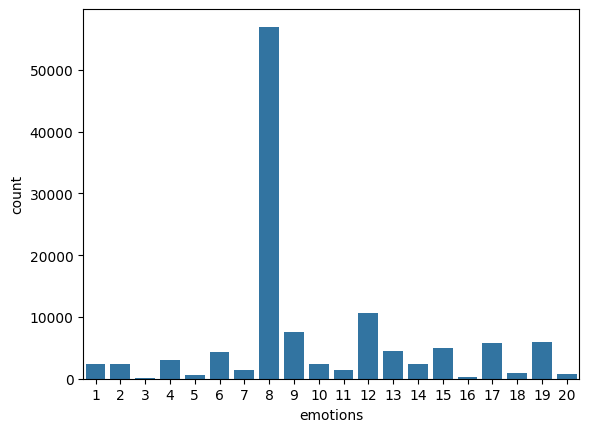

In [68]:
df_p = apply_model (cdf,df,test_size=0.2)
df_p

<Axes: xlabel='emotion', ylabel='count'>

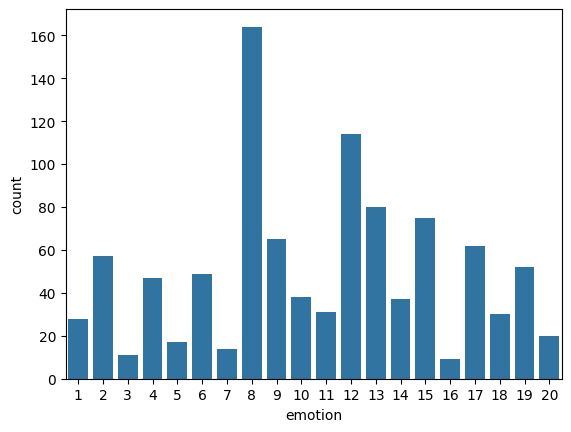

In [30]:
import seaborn as sns
sns.countplot(x=cdf.emotion)

In [101]:
df_p.to_csv("../data/final_df/boost.csv")

Unique Classes (Train): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Unique Classes (Test): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
------------XGBClassifier------------

Precision: 0.2164
Recall: 0.2320
F1 Score: 0.4950


Unique Classes (final): [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


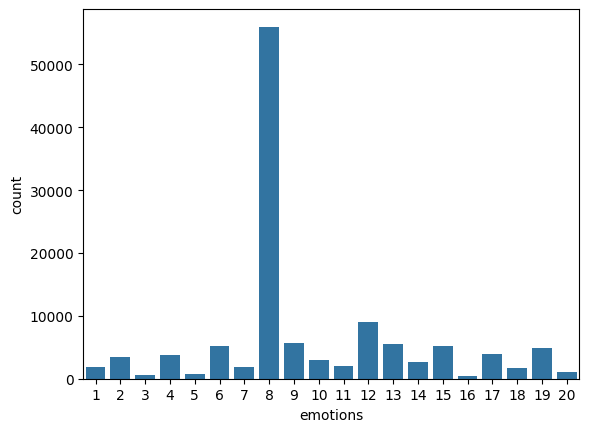

In [100]:
df_p6 = apply_model (cdf,df,test_size=0.25)

APPLY MODEL TO HOLE DATASET TREE

In [83]:
def apply_model_(model,df,df_2, n_iterations=1000,test_size=0.2):

    '''Function to apply the trained model to my full dataframe. It also plots.
    It takes 3 args:
    - df model
    - dataframe to predict
    - test size'''

    X = df["message"]
    y = df["emotion"]

    # Train / test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Vectorize
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)#.toarray()  # Convert to dense array
    X_test_tfidf = vectorizer.transform(X_test)#.toarray()  # Convert to dense array

    accuracy_bootstrap = []

    
    for _ in range(n_iterations):
        X_bs, y_bs = resample(X_train_tfidf, y_train)
        model.fit(X_bs, y_bs)
        y_pred = model.predict(X_test_tfidf)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        accuracy_bootstrap.append(accuracy)

    print(f"------------notas------------\n")
    print(f"Average Accuracy: {np.mean(accuracy_bootstrap):.4f}")
    print(f"Standard Deviation: {np.std(accuracy_bootstrap):.4f}")

    print(f"F1 Score: {metrics.f1_score(y_test, y_pred, average='weighted',zero_division=1):.4f}")
    print("\n")


    df_p = df_2.copy()
    df_p.dropna(inplace=True)
    X = vectorizer.transform(df_p["message"])
    y_pred = model.predict(X)

    df_p["emotions"] = y_pred
    df_p["emotions_names"] = df_p["emotions"].map(emotions_2)

    sns.countplot(x = df_p.emotions)

    df_p.to_csv("../data/final_df/Tree2.csv")

    return df_p

------------notas------------

Average Accuracy: 0.1732
Standard Deviation: 0.0223
F1 Score: 0.2954




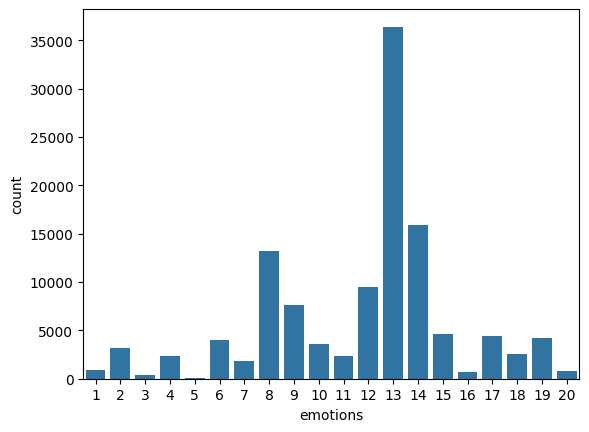

In [73]:
df_p2 = apply_model_(DecisionTreeClassifier(),cdf,df, n_iterations=1000,test_size=0.2)

In [76]:
df_p2.to_csv("../data/final df/tree_viable.csv")

------------notas------------

Average Accuracy: 0.2298
Standard Deviation: 0.0308
F1 Score: 0.4180




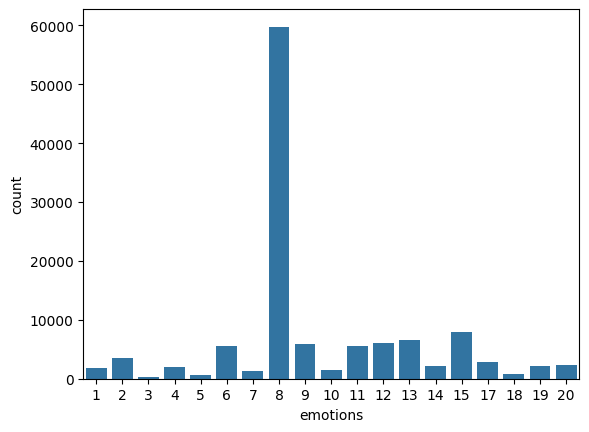

In [94]:
df_p5 = apply_model_(DecisionTreeClassifier(splitter='best',min_samples_split=10,min_samples_leaf=2,max_depth=None,criterion='entropy'),cdf,df, n_iterations=1000,test_size=0.1)

------------notas------------

Average Accuracy: 0.1822
Standard Deviation: 0.0287
F1 Score: 0.4903




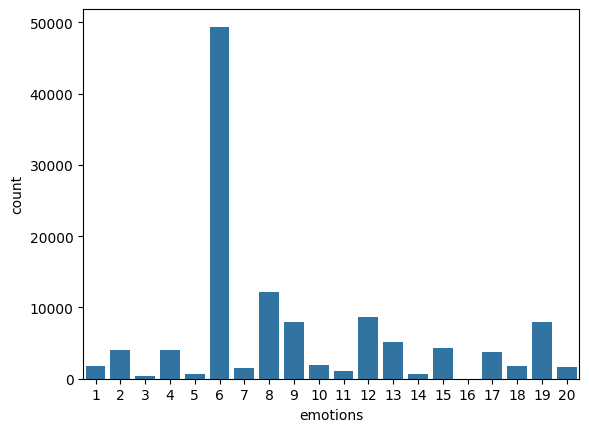

In [75]:
df_p4 = apply_model_(DecisionTreeClassifier(),cdf,df, n_iterations=1000,test_size=0.1)
df_p4

APPLY MODEL TO HOLE DATASET KNEI

------------notas------------

Average Accuracy: 0.1295
Standard Deviation: 0.0254
F1 Score: 0.4789




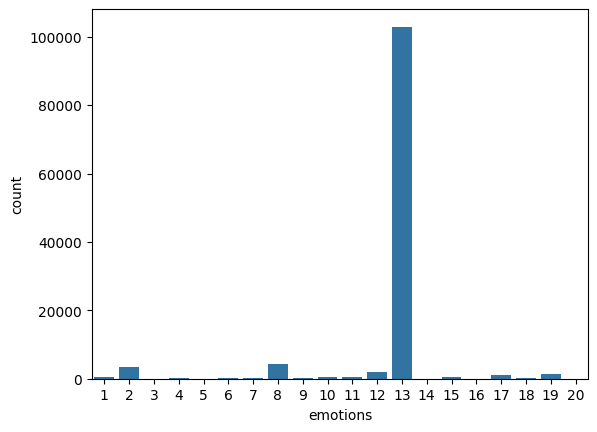

In [72]:
df_p3 = apply_model_(KNeighborsClassifier(),cdf,df, n_iterations=1000,test_size=0.2)

mcajklnflv

In [57]:
'''X_train, X_test, y_train, y_test = train_test_split(cdf["message"], cdf["emotion"], test_size=0.25, random_state=42)


vectorizer = TfidfVectorizer() # mirar parameters, buena info para tableau. count words...
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Diferentes modelos
# Bootstraping
clf = MultinomialNB() #bayes
clf.fit(X_train_tfidf, y_train)


# Make predictions
predictions = clf.predict(X_test_tfidf)


def test_on_new_df ():
    """fer estaba haciendo pruebas"""
    df_2 = df.copy()
    df_2.dropna(inplace=True)
    X = vectorizer.transform(df_2["message"])
    df_2["new"] = clf.predict(X)
    df_2["new_2"] = df_2["new"].map(emotions_2)
    return df_2
df_2 = test_on_new_df ()
df_2'''

'X_train, X_test, y_train, y_test = train_test_split(cdf["message"], cdf["emotion"], test_size=0.25, random_state=42)\n\n\nvectorizer = TfidfVectorizer() # mirar parameters, buena info para tableau. count words...\nX_train_tfidf = vectorizer.fit_transform(X_train)\nX_test_tfidf = vectorizer.transform(X_test)\n\n#\xa0Diferentes modelos\n#\xa0Bootstraping\nclf = MultinomialNB() #bayes\nclf.fit(X_train_tfidf, y_train)\n\n\n# Make predictions\npredictions = clf.predict(X_test_tfidf)\n\n\ndef test_on_new_df ():\n    """fer estaba haciendo pruebas"""\n    df_2 = df.copy()\n    df_2.dropna(inplace=True)\n    X = vectorizer.transform(df_2["message"])\n    df_2["new"] = clf.predict(X)\n    df_2["new_2"] = df_2["new"].map(emotions_2)\n    return df_2\ndf_2 = test_on_new_df ()\ndf_2'

In [108]:
df_4 = pd.read_csv("../data/final_df/h2o2.csv")

<Axes: xlabel='emotions', ylabel='count'>

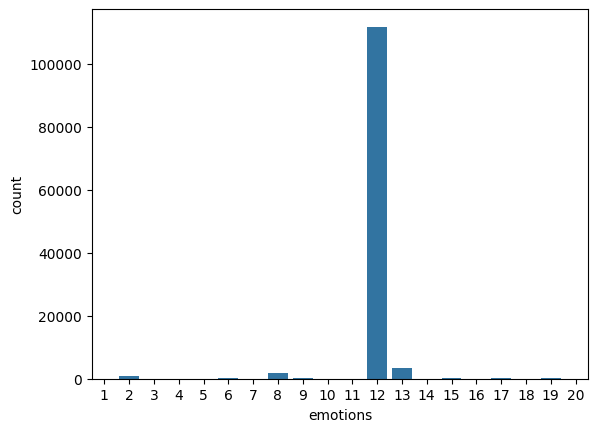

In [109]:
sns.countplot(x=df_4.emotions)